Install and load packages

In [1]:
!pip install shap -qq
!pip install sweetviz -qq

     |████████████████████████████████| 575 kB 4.7 MB/s 
     |████████████████████████████████| 15.1 MB 5.2 MB/s 


In [83]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap
import urllib.request
import gzip
import sweetviz as sv
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

Download data

In [84]:
#city listing summary adress url
URL_SOURCE = 'http://data.insideairbnb.com/spain/andaluc%C3%ADa/sevilla/2022-09-26/data/listings.csv.gz'

#download file
urllib.request.urlretrieve(URL_SOURCE, 'listings.csv.gz')

#open file csv.gz and read
with gzip.open('listings.csv.gz', 'rb') as f:
    file_content = f.read()

with open('sevilla_listings.csv', 'wb') as f:
    f.write(file_content)

In [85]:
#read data into dataframe
data_frame = pd.read_csv('sevilla_listings.csv')
data_frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6494 non-null   int64  
 1   listing_url                                   6494 non-null   object 
 2   scrape_id                                     6494 non-null   int64  
 3   last_scraped                                  6494 non-null   object 
 4   source                                        6494 non-null   object 
 5   name                                          6494 non-null   object 
 6   description                                   6491 non-null   object 
 7   neighborhood_overview                         4161 non-null   object 
 8   picture_url                                   6494 non-null   object 
 9   host_id                                       6494 non-null   i

Basic report

In [6]:
report = sv.analyze(data_frame, pairwise_analysis='off')
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Select atributes

In [86]:
selected_columns = ['price','bathrooms_text','accommodates','bedrooms','review_scores_cleanliness', 'amenities']
#and check their types
data_frame[selected_columns].dtypes

price                         object
bathrooms_text                object
accommodates                   int64
bedrooms                     float64
review_scores_cleanliness    float64
amenities                     object
dtype: object

In [87]:
data_frame[selected_columns].describe
data_frame[selected_columns].head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities
0,$99.00,1 bath,4,2.0,4.96,"[""TV"", ""Washer"", ""Bedroom comforts"", ""Elevator..."
1,$75.00,1 bath,3,1.0,4.97,"[""Shampoo"", ""Clothing storage: closet"", ""Air c..."
2,$79.00,1 shared bath,2,1.0,4.31,"[""Shampoo"", ""Air conditioning"", ""Refrigerator""..."
3,$84.00,1 bath,6,2.0,4.82,"[""Shampoo"", ""Bathtub"", ""45\"" HDTV with Chromec..."
4,$85.00,1 bath,6,2.0,4.64,"[""Shampoo"", ""Outdoor dining area"", ""Private fe..."


In [88]:
#check missing values
data_frame[selected_columns].isna().sum()

price                          0
bathrooms_text                 8
accommodates                   0
bedrooms                     316
review_scores_cleanliness    751
amenities                      0
dtype: int64

In [89]:
#remove NaN values
data = data_frame[selected_columns].dropna()
data.head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities
0,$99.00,1 bath,4,2.0,4.96,"[""TV"", ""Washer"", ""Bedroom comforts"", ""Elevator..."
1,$75.00,1 bath,3,1.0,4.97,"[""Shampoo"", ""Clothing storage: closet"", ""Air c..."
2,$79.00,1 shared bath,2,1.0,4.31,"[""Shampoo"", ""Air conditioning"", ""Refrigerator""..."
3,$84.00,1 bath,6,2.0,4.82,"[""Shampoo"", ""Bathtub"", ""45\"" HDTV with Chromec..."
4,$85.00,1 bath,6,2.0,4.64,"[""Shampoo"", ""Outdoor dining area"", ""Private fe..."


In [90]:
data.amenities[1000]

'["Shampoo", "TV", "Air conditioning", "Refrigerator", "Bed linens", "Fire extinguisher", "Room-darkening shades", "Hangers", "Crib", "Extra pillows and blankets", "Hair dryer", "Dedicated workspace", "Long term stays allowed", "Washer", "Luggage dropoff allowed", "Microwave", "Stove", "Iron", "Coffee maker", "Hot water", "Wifi", "Outlet covers", "Dishwasher", "Smoke alarm", "Dishes and silverware", "Free street parking", "Paid parking on premises", "Ethernet connection", "Oven", "Pack \\u2019n play/Travel crib", "Carbon monoxide alarm", "Babysitter recommendations", "Window guards", "Heating", "Kitchen", "Essentials", "High chair", "Elevator", "Shared pool", "Body soap", "Patio or balcony", "First aid kit", "Host greets you", "Cooking basics", "Baby bath"]'

In [91]:
#remove "" 
data.amenities = data_frame.amenities.apply(lambda x: x.replace('"',''))

#select interesting attributes form 'amenities' column
list_amenities = ['Air conditioning', 'Wifi', 'Kitchen', 'Microwave',
                  'Refrigerator', 'Iron', 'Full kitchen', 'Coffee maker',
                  'Dryer', 'Shared garden or backyard', 'Washer', 'Breakfast', 
                  'Toaster', 'Wine glasses', 'Dishwasher', 'Shared pool']

def separateAmenities(record):
  '''#slice each into a separate column, 
  add label True or False, change type to bool
  '''
  data[f"{record}"] = ''
  for index, row in data.iterrows():
    if f'{record}' in row.amenities:
      data.at[index, f'{record}'] = True
    else:
      data.at[index, f'{record}'] = False
    data[f'{record}'] = data[f'{record}'].astype(bool)

for each in list_amenities:
  separateAmenities(each)


In [114]:
#remove ' ' from column name
data.rename(columns={'Air conditioning': 'Air_conditioning',
                     'Shared garden or backyard': 'Shared_garden_or_backyard',
                     'Coffee maker': 'Coffee_maker',
                     'Full kitchen': 'Full_kitchen',
                     'Wine glasses': 'Wine_glasses',
                     'Shared pool': 'Shared_pool'}, inplace=True)
variables = list(data.columns)
variables

['price',
 'bathrooms_text',
 'accommodates',
 'bedrooms',
 'review_scores_cleanliness',
 'amenities',
 'Air_conditioning',
 'Wifi',
 'Kitchen',
 'Microwave',
 'Refrigerator',
 'Iron',
 'Full_kitchen',
 'Coffee_maker',
 'Dryer',
 'Shared_garden_or_backyard',
 'Washer',
 'Breakfast',
 'Toaster',
 'Wine_glasses',
 'Dishwasher',
 'Shared_pool',
 'bathrooms_number']

In [93]:
#cast price as float
data.price = data.price.apply(lambda x: x.replace('$',''))
data.price = data.price.apply(lambda x: x.replace(',',''))
data.price = pd.to_numeric(data.price, errors='coerce')
data.price.describe()

count    5468.000000
mean      133.179225
std       265.710509
min         9.000000
25%        68.000000
50%        98.000000
75%       142.000000
max      8000.000000
Name: price, dtype: float64

In [109]:
# Getting rid of outliers
print("99.5% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.5)))
data = data[(data.price <= np.percentile(data.price, 99.5)) & (data.price > 0)]

99.5% properties have a price lower than  302.21


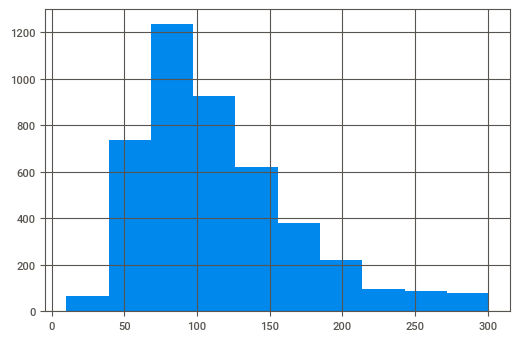

In [110]:
data.price.hist()

In [100]:
#replace number of bathrooms and change to int
data.bathrooms_text.unique()

array(['1 bath', '1 shared bath', '1.5 baths', '2 baths',
       '1.5 shared baths', '1 private bath', '3 baths', '0 shared baths',
       '3.5 baths', '2.5 baths', '4 baths', '3 shared baths',
       '2.5 shared baths', '2 shared baths', '6 shared baths', '6 baths',
       '8 shared baths', '4.5 baths', 'Shared half-bath', '5 baths',
       '3.5 shared baths', '15.5 baths', '13.5 baths', '0 baths'],
      dtype=object)

In [101]:
#take unique values from column bathrooms_text
bathrooms_options_list = ['1 bath','1.5 baths','2 baths',
                          '3 baths','3.5 baths','2.5 baths','4 baths','5 baths',
                          '7.5 baths', '6 baths', '4.5 baths','5.5 baths',
                          '15.5 baths','6.5 baths', '13.5 baths', '7 baths', '0 baths']

#drop rows with values different than in list above
data.drop(data[~data['bathrooms_text'].isin(bathrooms_options_list)].index, inplace=True)


In [102]:
#get numbers from column bathroom_text
data[['bathrooms_number','bathrooms_text2']] = data.bathrooms_text.str.split('b',expand=True)
data.drop('bathrooms_text2', inplace=True, axis=1)
data.bathrooms_number.unique()

array(['1 ', '1.5 ', '2 ', '3 ', '3.5 ', '2.5 ', '4 ', '6 ', '4.5 ', '5 ',
       '15.5 ', '13.5 ', '0 '], dtype=object)

In [103]:
#save column bathroom_number as float
data.bathrooms_number = data.bathrooms_number.astype(float)
data.head()

,price,bathrooms_text,accommodates,bedrooms,review_scores_cleanliness,amenities,Air_conditioning,Wifi,Kitchen,Microwave,...,Coffee_maker,Dryer,Shared_garden_or_backyard,Washer,Breakfast,Toaster,Wine_glasses,Dishwasher,Shared_pool,bathrooms_number
0,99.0,1 bath,4,2.0,4.96,"[TV, Washer, Bedroom comforts, Elevator, Bathr...",True,True,False,False,...,True,True,False,True,False,False,False,False,False,1.0
1,75.0,1 bath,3,1.0,4.97,"[Shampoo, Clothing storage: closet, Air condit...",True,True,True,True,...,True,True,False,True,False,True,True,False,False,1.0
3,84.0,1 bath,6,2.0,4.82,"[Shampoo, Bathtub, 45\ HDTV with Chromecast, s...",False,True,True,True,...,True,False,True,False,False,True,True,True,False,1.0
4,85.0,1 bath,6,2.0,4.64,"[Shampoo, Outdoor dining area, Private fenced ...",False,True,True,True,...,True,False,False,False,False,False,False,False,False,1.0
5,83.0,1 bath,4,1.0,4.68,"[Shampoo, Private fenced garden or backyard, R...",False,True,True,True,...,True,False,False,False,False,False,False,True,False,1.0


Modelling

In [111]:
model = smf.ols('price ~ accommodates + bedrooms + review_scores_cleanliness + bathrooms_number + Wifi + Air_conditioning + Kitchen + Microwave + Refrigerator + Iron + Full_kitchen + Coffee_maker + Dryer + Shared_garden_or_backyard + Air_conditioning + Full_kitchen + Coffee_maker + Shared_garden_or_backyard + Washer + Breakfast + Toaster + Wine_glasses + Dishwasher + Shared_pool', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     91.30
Date:                Thu, 29 Dec 2022   Prob (F-statistic):          4.78e-313
Time:                        16:36:26   Log-Likelihood:                -23291.
No. Observations:                4457   AIC:                         4.662e+04
Df Residuals:                    4436   BIC:                         4.676e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Lasso

(0.0007073435436139703,
 38.085826883641246,
 -3.707033911752923,
 16.17678092898229)

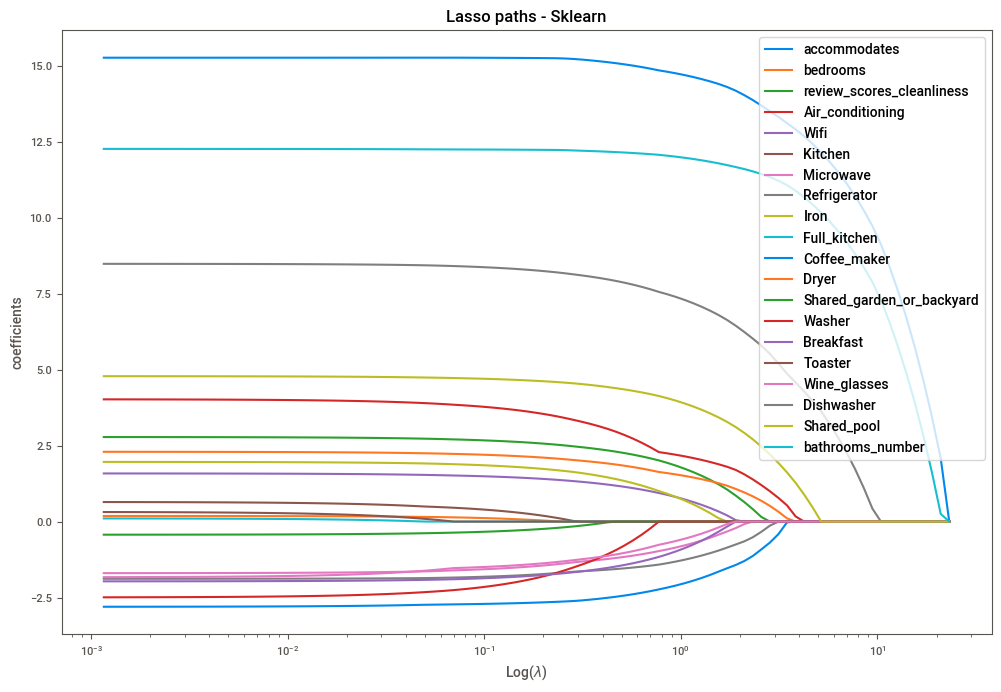

In [122]:
#variables = ['accommodates', 'bedrooms', 'bathrooms_number', 'review_scores_cleanliness', 'Wifi', 'Air_conditioning', 'Kitchen', 'Microwave']
variables = [
 'accommodates',
 'bedrooms',
 'review_scores_cleanliness',
 'Air_conditioning',
 'Wifi',
 'Kitchen',
 'Microwave',
 'Refrigerator',
 'Iron',
 'Full_kitchen',
 'Coffee_maker',
 'Dryer',
 'Shared_garden_or_backyard',
 'Washer',
 'Breakfast',
 'Toaster',
 'Wine_glasses',
 'Dishwasher',
 'Shared_pool',
 'bathrooms_number']
data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

xgBoost

In [123]:
# XGBoost

#variables = ['accommodates', 'bedrooms', 'bathrooms_number', 'review_scores_cleanliness', 'Wifi', 'Air_conditioning', 'Kitchen', 'Microwave']
data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:100000,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = xgboost.XGBRegressor(n_estimators=1000, verbosity=1)
model.fit(X_train, y_train)

[16:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [124]:
predicted = model.predict(X_test)
mean_squared_error(y_test, predicted)

1999.2255718307485

Shapley

In [125]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [126]:
X.iloc[0,:]

accommodates                     4
bedrooms                       2.0
review_scores_cleanliness     4.96
Air_conditioning              True
Wifi                          True
Kitchen                      False
Microwave                    False
Refrigerator                 False
Iron                          True
Full_kitchen                  True
Coffee_maker                  True
Dryer                         True
Shared_garden_or_backyard    False
Washer                        True
Breakfast                    False
Toaster                      False
Wine_glasses                 False
Dishwasher                   False
Shared_pool                  False
bathrooms_number               1.0
Name: 0, dtype: object

In [127]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

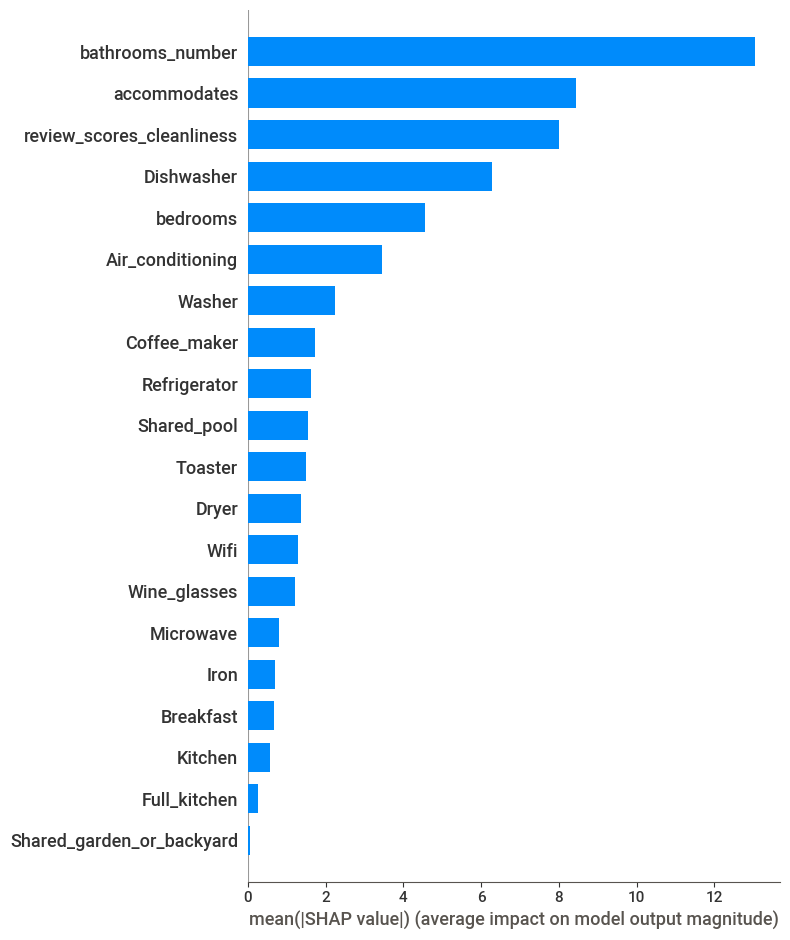

In [128]:
shap.summary_plot(shap_values, X, plot_type="bar")

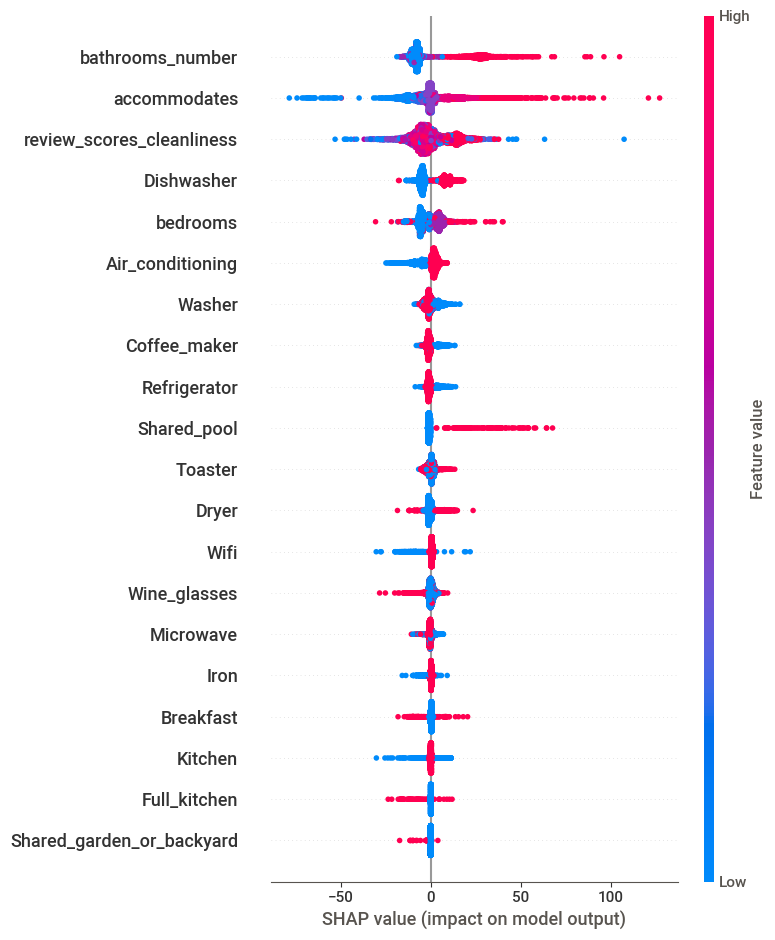

In [129]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)